# ST590 - Project 2

Authored by Group 13 - Dave Bergeron, Xavier Genelin, and Maksim Nikiforov

## Introduction

In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sqlite3

This report will investigate the contents of a small business database, _Northwind_, which contains information on employees and their sales territories, customers, orders, products, and product suppliers. In totality, the database contains fourteen tables, the names of which we can retrieve by querying the schema table below. The aim of this exercise is to understand how much product each employee has sold and in which territories, employee sales performance during the years spanning 1996-1998, and performance in each region. This report will conclude with an assessment of each employee and suggestions for improvement. 

In [2]:
# Connect to the database and retrieve all table names
con = sqlite3.connect("northwind.sqlite")
pd.read_sql('SELECT * FROM sqlite_schema WHERE type = \'table\' ORDER BY name', con)

,type,name,tbl_name,rootpage,sql
0,table,Categories,Categories,2,CREATE TABLE [Categories]\n( [CategoryID]...
1,table,CustomerCustomerDemo,CustomerCustomerDemo,28,CREATE TABLE [CustomerCustomerDemo](\n [Cust...
2,table,CustomerDemographics,CustomerDemographics,30,CREATE TABLE [CustomerDemographics](\n [Cust...
3,table,Customers,Customers,32,CREATE TABLE [Customers]\n( [CustomerID] ...
4,table,EmployeeTerritories,EmployeeTerritories,68,CREATE TABLE [EmployeeTerritories](\n [Emplo...
5,table,Employees,Employees,38,CREATE TABLE [Employees]\n( [EmployeeID] ...
6,table,Order Details,Order Details,70,CREATE TABLE [Order Details](\n [OrderID]INT...
7,table,Orders,Orders,92,CREATE TABLE [Orders](\n [OrderID]INTEGER NO...
8,table,Products,Products,128,CREATE TABLE [Products](\n [ProductID]INTEGE...
9,table,Regions,Regions,132,CREATE TABLE [Regions](\n [RegionID]INTEGER ...


## Business assessments

The _Employees_ table contains information on nine individuals whose employee identifications range of 1 to 9. One employee is a vice president, one employee is a sales manager, and six employees are sales representatives. The six representatives have access to one insides sales coordinator who presumably helps fulfill orders, ensures timely delivery, and assists with other logistics. Five employees report to the vice president, Andrew, and three employees report to the sales manager, Steven.   

In [39]:
# Retrieve employee IDs, names, titles, hire dates, and reporting structure
emp_desc = pd.read_sql("""
SELECT EmployeeID
    ,FirstName || " " || LastName AS Employee
    ,Title 
    ,HireDate
    ,ReportsTo
FROM Employees
""", con)

emp_desc

,EmployeeID,Employee,Title,HireDate,ReportsTo
0,1,Nancy Davolio,Sales Representative,1992-05-01,2.0
1,2,Andrew Fuller,"Vice President, Sales",1992-08-14,NaN
2,3,Janet Leverling,Sales Representative,1992-04-01,2.0
3,4,Margaret Peacock,Sales Representative,1993-05-03,2.0
4,5,Steven Buchanan,Sales Manager,1993-10-17,2.0
5,6,Michael Suyama,Sales Representative,1993-10-17,5.0
6,7,Robert King,Sales Representative,1994-01-02,5.0
7,8,Laura Callahan,Inside Sales Coordinator,1994-03-05,2.0
8,9,Anne Dodsworth,Sales Representative,1994-11-15,5.0


We can assess this further by looking at the amount of work each person is responsible for by looking at the number of territories and regions each employee has, while also looking at the number of orders and products they have dealt with. 

In [4]:
# look at how many territories and regions each employee are responsible for as well as the number 
# of orders and products they have
pd.read_sql("""
WITH territory AS (
SELECT emp.FirstName || " " ||  emp.LastName AS Employee
    ,emp.EmployeeID
    ,emp.Title
    ,COUNT(DISTINCT ter.TerritoryDescription) AS Territories
FROM Employees emp
    LEFT JOIN EmployeeTerritories empter
        ON emp.EmployeeID = empter.EmployeeID
    LEFT JOIN Territories ter 
        ON empter.TerritoryID = ter.TerritoryID
GROUP BY emp.FirstName
    ,emp.LastName
    ,emp.Title
    ,emp.EmployeeID
),

region AS (
SELECT emp.FirstName || " " ||  emp.LastName AS Employee
    ,COUNT(DISTINCT reg.RegionID) AS Regions
FROM Employees emp
    LEFT JOIN EmployeeTerritories empter
        ON emp.EmployeeID = empter.EmployeeID
    LEFT JOIN Territories ter 
        ON empter.TerritoryID = ter.TerritoryID
    LEFT JOIN Regions reg 
        ON ter.RegionID = reg.RegionID
GROUP BY emp.FirstName
    ,emp.LastName
),

orders_products AS (
SELECT a.EmployeeID 
    ,COUNT(DISTINCT c.ProductID) AS Products
    ,COUNT(DISTINCT a.OrderID) AS Orders
FROM Orders a 
    LEFT JOIN [Order Details] b
        ON a.OrderID = b.OrderID 
    LEFT JOIN Products c
        ON b.ProductID = c.ProductID
        
GROUP BY a.EmployeeID
)

SELECT a.Employee
    ,a.Title
    ,a.Territories
    ,b.Regions
    ,c.Orders
    ,c.Products
FROM territory a
    LEFT JOIN region b
        ON a.Employee = b.Employee
    LEFT JOIN orders_products c
        ON a.EmployeeID = c.EmployeeID
        
ORDER BY a.Territories DESC
 """, con)

,Employee,Title,Territories,Regions,Orders,Products
0,Robert King,Sales Representative,10,1,72,67
1,Andrew Fuller,"Vice President, Sales",7,1,96,68
2,Anne Dodsworth,Sales Representative,7,1,43,53
3,Steven Buchanan,Sales Manager,6,1,42,52
4,Michael Suyama,Sales Representative,5,1,67,57
5,Janet Leverling,Sales Representative,4,1,127,74
6,Laura Callahan,Inside Sales Coordinator,4,1,104,70
7,Margaret Peacock,Sales Representative,3,1,156,75
8,Nancy Davolio,Sales Representative,2,1,123,72


We can also look into what specific territories and regions each employee is responsible for. 

In [43]:
# get the specific territories for each employee 
emp_terr_region = pd.read_sql("""
SELECT emp.FirstName || " " ||  emp.LastName AS Employee
    ,TRIM(ter.TerritoryDescription) AS TerritoryDescription
    ,TRIM(reg.RegionDescription) AS RegionDescription
FROM Employees emp
    LEFT JOIN EmployeeTerritories empter
        ON emp.EmployeeID = empter.EmployeeID
    LEFT JOIN Territories ter 
        ON empter.TerritoryID = ter.TerritoryID
    LEFT JOIN Regions reg 
        ON ter.RegionID = reg.RegionID
ORDER BY emp.FirstName
    ,emp.LastName
    ,ter.TerritoryDescription
""", con)

emp_terr_region

,Employee,TerritoryDescription,RegionDescription
0,Andrew Fuller,Bedford,Eastern
1,Andrew Fuller,Boston,Eastern
2,Andrew Fuller,Braintree,Eastern
3,Andrew Fuller,Cambridge,Eastern
4,Andrew Fuller,Georgetow,Eastern
5,Andrew Fuller,Louisville,Eastern
6,Andrew Fuller,Westboro,Eastern
7,Anne Dodsworth,Bloomfield Hills,Northern
8,Anne Dodsworth,Hollis,Northern
9,Anne Dodsworth,Minneapolis,Northern


We can assess the performance of each individual by understanding how much they sell. To do this, we can combine information from the _Orders_ table with additional details from the _Order Details_ table. We see that Margaret Peacock sold the most amount of product, bringing in $\$232,890.85$ in sales (assuming a US Dollar currency). As sales representatives, Michael Suyama and Anne Dodsworth sold three times less, suggesting that there is room for improvement. 

In [38]:
# Retrieve total quantities sold by each employee and 
# create a new column to identify total sales 
emp_sales_total = pd.read_sql("""
WITH main AS (
SELECT ord.EmployeeID 
    ,ord.OrderID
    ,ord.OrderDate
    ,det.ProductID 
    ,det.UnitPrice	
    ,det.Quantity
    ,det.Discount
    ,(det.UnitPrice - det.UnitPrice*det.Discount)*det.Quantity AS TotalSale
FROM Orders ord
    LEFT JOIN [Order Details] det
        ON ord.OrderID = det.OrderID
)

-- Get the total Quantity and sales for each employee
SELECT b.FirstName || " " ||  b.LastName AS Employee
    ,b.Title
    ,SUM(Quantity) AS Quantity
    ,SUM(TotalSale) AS TotalSale
FROM main a 
    LEFT JOIN Employees b
        ON a.EmployeeID = b.EmployeeID
GROUP BY a.EmployeeID
    ,b.FirstName
    ,b.LastName
    ,b.title
ORDER BY TotalSale DESC
""", con)

emp_sales_total

,Employee,Title,Quantity,TotalSale
0,Margaret Peacock,Sales Representative,9798,232890.8460
1,Janet Leverling,Sales Representative,7852,202812.8430
2,Nancy Davolio,Sales Representative,7812,192107.6045
3,Andrew Fuller,"Vice President, Sales",6055,166537.7550
4,Laura Callahan,Inside Sales Coordinator,5913,126862.2775
5,Robert King,Sales Representative,4654,124568.2350
6,Anne Dodsworth,Sales Representative,2670,77308.0665
7,Michael Suyama,Sales Representative,3527,73913.1295
8,Steven Buchanan,Sales Manager,3036,68792.2825


How do these employee sales reflect regional performance? By associating the total sales of each employee with the region assigned to that employee, we find that, at $\$660,328.49$,  the Eastern region brought in more sales than all other regions combined. 

In [100]:
# Retrieve employee names and their regions from a previous data frame (emp_terr_region) and drop duplicate Employee/Region rows
temp_region_desc = emp_terr_region[["Employee", "RegionDescription"]].drop_duplicates()

# Enrich the emp_sales_total table above with regional data
region_sales = pd.merge(
    left = emp_sales_total,
    right = temp_region_desc, 
    how = "left", 
    on = "Employee")

# Calculate total sales for each region
sum_region_sales = region_sales[["TotalSale", "RegionDescription"]].groupby("RegionDescription").sum("TotalSale")
sum_region_sales.sort_values(by="TotalSale", ascending=False)

,TotalSale
RegionDescription,
Eastern,660328.4880
Northern,204170.3440
Southern,202812.8430
Westerns,198481.3645


We can better visualize regional performance using a pie plot, which shows that the Eastern region brought in 52.17% of all sales in the company. The Northern and Southern regions performed on par with one another at just over 16% of total sales.

Text(0.5, 1.0, 'Percentage of Total Sales per Region \n 1996-1998')

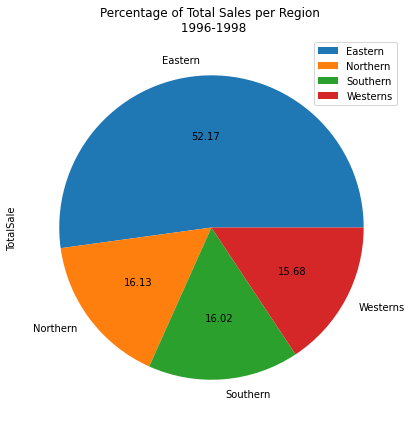

In [96]:
# Pie chart with percentage of total sales brought in by each region 
sum_region_sales.plot.pie(y="TotalSale", autopct="%.2f", figsize=(7, 7))
plt.title("Percentage of Total Sales per Region \n 1996-1998")

We can also assess annual sales for each employee.

In [7]:
# Retrieve annual sale figures
orders_per_employee = pd.read_sql("""
SELECT ord.EmployeeID
    ,emp.FirstName || " " || emp.LastName AS Employee
    ,strftime('%Y', ord.OrderDate) AS OrderYear
    ,ord.OrderDate
    ,(det.UnitPrice - det.UnitPrice*det.Discount)*det.Quantity AS TotalSale
    ,det.Quantity
    ,det.Discount
    ,det.ProductID
    ,det.UnitPrice
FROM Orders ord
    LEFT JOIN [Order Details] det
        ON ord.OrderID = det.OrderID
    LEFT JOIN Employees emp
        ON ord.EmployeeID = emp.EmployeeID
""", con)

# Convert "OrderDate" column to DateTime in pandas
orders_per_employee["OrderDate"] = pd.to_datetime(orders_per_employee["OrderDate"])

# Extract quarter from the "OrderDate" DateTime column and save it in a new column
orders_per_employee["OrderQuarter"] = orders_per_employee["OrderDate"].dt.to_period('Q')

# Sum up sales and group by EmployeeID and OrderYear, then view the result 
annual_emp_sales = orders_per_employee[["OrderYear", "TotalSale", "Employee"]] \
                          .groupby(["Employee", "OrderYear"]) \
                          .sum("TotalSale")

annual_emp_sales

TotalSale
Employee         OrderYear             
Andrew Fuller    1996        21757.0600
                 1997        70444.1400
                 1998        74336.5550
Anne Dodsworth   1996         9894.5150
                 1997        26310.3925
                 1998        41103.1590
Janet Leverling  1996        18223.9600
                 1997       108026.1555
                 1998        76562.7275
Laura Callahan   1996        22240.1200
                 1997        56032.6150
                 1998        48589.5425
Margaret Peacock 1996        49945.1150
                 1997       128809.7910
                 1998        54135.9400
Michael Suyama   1996        16642.6050
                 1997        43126.3695
                 1998        14144.1550
Nancy Davolio    1996        35764.5150
                 1997        93148.0775
                 1998        63195.0120
Robert King      1996        15232.1600
                 1997        60471.1950
                 1998        48864.8800
Steven Buchanan  1996        18383.9200
                 1997        30716.4675
                 1998        19691.8950

We can interpret this information more easily by plotting annual sales for each employee side-by-side. In all cases, employees sold more product in 1997 than in 1996. Moreover, while most employees saw sales decline in 1998, Andrew Fuller and Anne Dodsworth continued to grow their sales year-over-year. 

Text(0, 0.5, 'Total Sales')

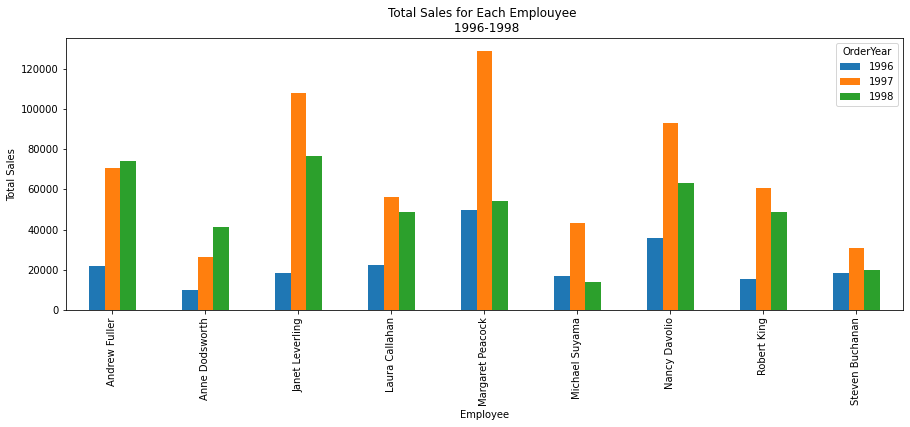

In [17]:
# Reset index to ensure that we have a column of employee names
annual_emp_sales_filtered = annual_emp_sales.reset_index()

# Create a pivot table with "TotalSale" as value, the names of employee as the index, and the years as columns
annual_emp_sales_pivot = pd.pivot_table(annual_emp_sales_filtered, values = "TotalSale", index="Employee", columns="OrderYear")

# Plot the annual sales for each employee using a side-by-side bar plot
annual_emp_sales_pivot.plot.bar(figsize=(15, 5))

# Horizontal bar plot of top-selling products
plt.title("Total Sales for Each Emplouyee \n 1996-1998")
plt.ylabel("Total Sales")

For a more granular view, we can use a line chart to visualize quarterly employee sales. We can limit the chart to the top and bottom two sales representatives to minimize clutter. We see that Janet Leverling, the top seller, performed on par with Michael and Anne in 1996. However, her quarterly sales increased six-fold from $\$10,000$ in Q3 of 1997 to $\$60,000$ in Q1 of 1998. The performance of Margaret Peacock, the second best seller, remained stable within the $\$20,000$-$\$40,000$ range. Compared to Michael Suyama, Anne Dodsworth under-performed until Q1 of 1998, when her sales also experienced a spike and placed her just above Michael for total sales across 1996-1998. 

In [9]:
# Sum up sales and group by EmployeeID and OrderQuarter.
monthly_employee_sales = orders_per_employee[["OrderQuarter", "TotalSale", "EmployeeID"]] \
                          .groupby(["EmployeeID", "OrderQuarter"]) \
                          .sum("TotalSale")

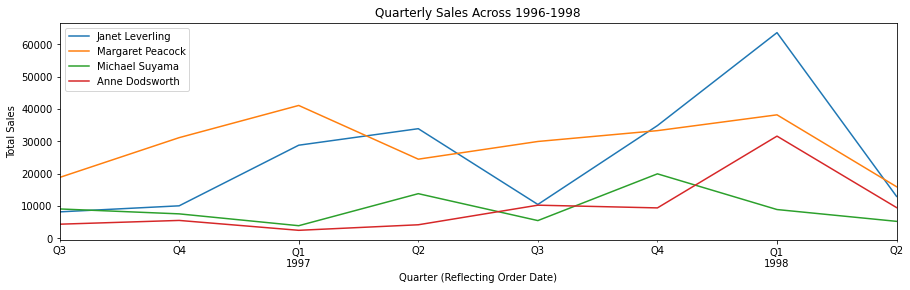

In [10]:
# Reset index to make EmployeeID and OrderQuarter columns available as columns in the data frame
monthly_sales_index_reset = monthly_employee_sales.reset_index()

# Filter result to include only the top two sellers (EmployeeID of 4 and 3)
# and the bottom two sellers (EmployeeID of 9 and 6)
top_bottom_performers = monthly_sales_index_reset[monthly_sales_index_reset["EmployeeID"].isin([4, 3, 9, 6])]

# Create a line chart. Modify the width for an expanded view. 
top_bottom_performers.set_index("OrderQuarter").groupby("EmployeeID")["TotalSale"].plot(legend=True, figsize=(15, 4))
plt.title("Quarterly Sales Across 1996-1998")
plt.ylabel("Total Sales")
plt.xlabel("Quarter (Reflecting Order Date)")
plt.legend(["Janet Leverling", "Margaret Peacock", "Michael Suyama", "Anne Dodsworth"])

Which products are being sold the most? After plotting the top ten products sold, we see that CÃ´te de Blaye (Côtes-de-Blaye?) is the most popular sales item with over $\$140,000$ sold, followed by Thüringer Rostbratwurst at just over $\$80,000$ and Raclette Courdavault at $\$71,155$.

Text(0, 0.5, 'Product Name')

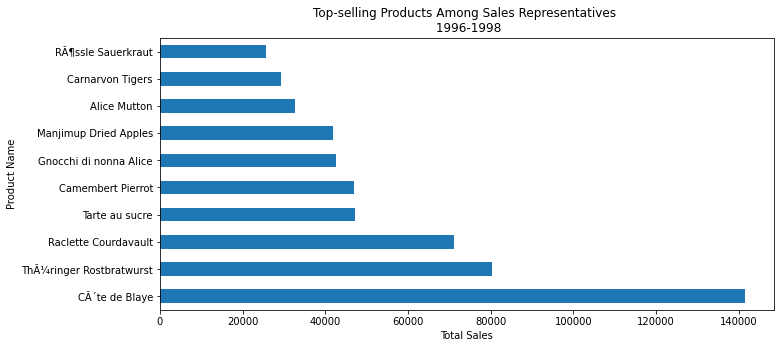

In [34]:
# Retrieve ProductID and find total sales (after grouping by ProductID and summing)
top_selling = orders_per_employee[["ProductID", "TotalSale"]] \
    .groupby("ProductID") \
    .sum("TotalSale") \
    .sort_values(by=["TotalSale"], ascending=False)

# Merge ProductID with product names for clarity (include only top 10 best-selling products)
top_selling_desc = pd.merge(
    left = top_selling,
    right = pd.read_sql("SELECT ProductID, ProductName FROM Products", con),
    how = "left", 
    on = "ProductID").head(10)

# Horizontal bar plot of top-selling products
top_selling_desc.plot.barh(y="TotalSale", x="ProductName", figsize=(11, 5), legend=False)
plt.title("Top-selling Products Among Sales Representatives \n 1996-1998")
plt.xlabel("Total Sales")
plt.ylabel("Product Name")

We can marge several data frames and tables to retrieve a data frame with more granular information for each sales representative. For example, we see that Anne Dodsworth and Steven Buchanan both excelled at selling wine and cheese, but Anne sold roughly twice as much in each category as Steven. Nancy Davolio and Laura Callahan also had success selling healthy alternatives such as dried apples and pears alongside Rostbratwurst and wine, which may yield a training opportunity in cross-selling for other sales representatives. 

In [12]:
# Group by EmployeeID and ProductID, then sort in descending order
# based on total sales 
emp_product_sales = orders_per_employee[["EmployeeID", "ProductID", "Quantity", "TotalSale"]]\
            .groupby(["EmployeeID", "ProductID"]) \
            .sum("TotalSale") \
            .sort_values(by=["EmployeeID", "TotalSale"], ascending=False).reset_index()

# View the top 2 ProductIDs sold by each sales representatives
top_two_sold = emp_product_sales.groupby("EmployeeID").head(2)

# Supplement ProductID with ProductName and CategoryID
product_sales = pd.merge(
    left = top_two_sold,
    right = pd.read_sql("SELECT ProductID, ProductName, UnitPrice, CategoryID FROM Products", con), 
    how = "left", 
    on = "ProductID")

# Retrieve categories, descriptions
descriptive_product_sales = pd.merge(
    left = product_sales,
    right = pd.read_sql("SELECT CategoryID, CategoryName, Description FROM Categories", con), 
    how = "left", 
    on = "CategoryID")

# Retrieve sales representative names
named_product_sales = pd.merge(
    left = descriptive_product_sales,
    right = pd.read_sql("SELECT LastName, FirstName, EmployeeID FROM Employees", con), 
    how = "left", 
    on = "EmployeeID")

# Filter columns for better presentability
named_product_sales[["EmployeeID", "LastName", "FirstName", "ProductName", "Description", "CategoryName", "UnitPrice", "Quantity", "TotalSale"]]

,EmployeeID,LastName,FirstName,ProductName,Description,CategoryName,UnitPrice,Quantity,TotalSale
0,9,Dodsworth,Anne,CÃ´te de Blaye,"Soft drinks, coffees, teas, beers, and ales",Beverages,263.50,57,14624.250
1,9,Dodsworth,Anne,Raclette Courdavault,Cheeses,Dairy Products,55.00,284,14201.550
2,8,Callahan,Laura,ThÃ¼ringer Rostbratwurst,Prepared meats,Meat/Poultry,123.79,94,9244.825
3,8,Callahan,Laura,Uncle Bob's Organic Dried Pears,Dried fruit and bean curd,Produce,30.00,276,8190.000
4,7,King,Robert,CÃ´te de Blaye,"Soft drinks, coffees, teas, beers, and ales",Beverages,263.50,99,16695.360
5,7,King,Robert,ThÃ¼ringer Rostbratwurst,Prepared meats,Meat/Poultry,123.79,146,14669.115
6,6,Suyama,Michael,Raclette Courdavault,Cheeses,Dairy Products,55.00,146,6671.500
7,6,Suyama,Michael,Gnocchi di nonna Alice,"Breads, crackers, pasta, and cereal",Grains/Cereals,38.00,178,6232.000
8,5,Buchanan,Steven,Raclette Courdavault,Cheeses,Dairy Products,55.00,144,7584.500
9,5,Buchanan,Steven,CÃ´te de Blaye,"Soft drinks, coffees, teas, beers, and ales",Beverages,263.50,40,6324.000


## Employee summaries

- **Nancy Davolio** - Nancy had the third highest amount of sales among the employees.  She also had the least number of territories at two.  In terms or ratios, she is seeing sales of $96,000 per territory which is the highest in the group.  In 1996 her sales were toward the bottom of the pack, however in 1997 she had the second highest number and was the top seller in 1998.  Nancy should consider expanding her territories as she has demonstrated her sales ability to saturate her market and could do well to expand her sales strategy to other areas.

- **Andrew Fuller** - Andrew had higher sales in 1997 and 1998 compared to his first year, and both years are relatively similar which indicate he's consistent. He is in the middle of the pack with sales numbers, and has a higher number of territories than other employees.  Within the eastern region, he has the highest number of territories at seven, but has the third highest amount of sales in the region.  The employee who had the lease amount of sales in the eastern region had one less territory than Andrew did, while the top two sellers in the Eastern regions had half the territories.  Andrew should consider decreasing the number of territories he covers in order to focus his sales in a more concentrated market and see if that leads to higher sales as he may be overextended geographically.  

- **Janet Leverling** - Janet has the second highest profit and sales of the employees. Her sales fluctuate a little, as we saw earlier in the quarterly sales graph. She could improve a little by stabilizing those sales, although she already has a good sales record.  She is the only representative among the employees in the southern region with a manageable amount of territories.  She may want to continue her sales strategy and see if new opportunities emerge or if more territories can be absorbed.

- **Margaret Peacock** - Margaret has sold the most items and has the highest profit of all the employees.  She also has one of the smallest number of territories among the group.  Her sales were in the middle of the pack in 1996 but then saw consistent growth in 1997 and 1998.  Margaret should continue her sales strategy and consider increasing her territories and possibly her product mix as well, considering adding dried fruits and beans similar to what Nancy Davolio has been selling in the eastern region which seem to sell well.   

- **Steven Buchanan** - Steven had the least amount of sales among the group.  He has the second highest number of territories in the eastern region with the least amount of sales in the region as well.  His sales were in the middle of the group in 1996 then had stayed in the second from last in 1997 and 1998.  Steven should consider reducing his number of territories consistent with Maragert and Nancy.  He should also consider his product mix.  For example, Steven and Margaret are both selling CÃ´te de Blaye in the eastern region, but Margaret is selling three times as much.  Steven may want to see if different marketing is needed, or if other products may sell better in his territories.

- **Michael Suyama** - Michael is second to last in total sales among the group.  His sales were low in 1996, but remained consistently in the middle for 1997 and 1998.  Michael has half the number of territories in the western region compared to Robert, who has almost twice as much in sales as Michael.  Michael may want to consider taking on a greater number of territories and also consider products with higher unit prices to see if that will bolster sales numbers.

- **Robert King** - Robert is around the middle of the group in total sales.  His sales were consistent in 1996 and 1997 then fell to the bottom in 1998.  Robert has the highest number of territories overall and in the Western Region.  Robert may want to consider decreasing his territories and see if he can focus efforts toward a great number of sales in a smaller market.

- **Laura Callahan** - Laura is in the middle of the group in terms of total sales.  She had the largest sales in 1996 and 1997 then dropped to the middle of the group in 1998.  She has a less than average amount of territories among the group and the least in the northern region.  In terms of sales per territory, she is the forth highest with sales per territory around $31,000.  She may want to consider her product mix and see another item may sell better compared to the ThÃ¼ringer Rostbratwurst as others in the group seem to be selling 30% more of that product in their areas.

- **Anne Dodsworth** - Anne is the third lowest in total sales.  She has consistently been in the top third of sales year over year from 1996 to 1998.  She has the second largest number of territories among the group, and sees sales of $11,000 per territory in the Northern region.  Anne may want to look at decreasing her number of territories and see if focusing her sales strategy in a smaller market may increase overall sales.  She may also consider seeing if she can increase sales of CÃ´te de Blaye or see if there is another product which may sell better in her region.